## PIV et Tracking en Python


### Généralités

Il arrive assez souvent de devoir mesurer des champs de vitesse ou de déplacement de particules ou de traceurs dans des fluides. Parfois, il est possible de localiser et d'identifier individuellement des particules, notamment à faible concentration et pour des particules assez grosses (ou un zoom élevé). Dans ce cas, il est tentant d'effectuer du _suivi individuel_ de particules (appelé _tracking_ ou PTV en anglais pour _Particle Tracking Velocimetry_), à partir duquel on pourra ensuite déterminer des déplacements ou des vitesses individuels. Dans le cas inverse, si les traceurs sont vraiment petits, que ces derniers sortent régulièrement du plan d'illumination, ou que leur concentration rend le suivi individuel déraisonnable, il sera plus sage d'utiliser la _PIV_ (pour _Particle Image Velocimetry_), qui va elle mesurer des champs de vitesses à partir de « boîtes » de petite taille par rapport à l'image : une taille typique de boîte de PIV est de 32 x 32 pixels. 

Il existe deux librairies distinctes pour effectuer la _PTV_ et la _PIV_. Ils sont : 
* [`trackpy`](http://soft-matter.github.io/trackpy/v0.5.0/) pour la PTV. Il est bien maintenu et sa documentation est très complète.
* [`openpiv`](http://www.openpiv.net/) pour la PIV. Ce paquet est moins bien maintenu, et sa documentation est moins complète. Le module fait quand même le boulot. 

### Trackpy

Le paquet `trackpy` s'appuie sur [un algorithme de détection et de suivi de particules développé dans les années 1990](https://www.sciencedirect.com/science/article/pii/S0021979796902179) par [John Crocker](https://crocker.seas.upenn.edu/members.html) et [David Grier](https://physics.nyu.edu/grierlab/). Il s'appuie sur 
* plusieurs opérations sur des images brutes pour détecter des particules que nous vue dans le tutoriel sur [`Scikit-Image`](./Application_E_ScikitImage.ipynb). Dans `trackpy`, c'est le rôle des fonctions `trackpy.locate()` et `trackpy.batch()`. 
* ainsi que sur une opération de chaînage (_linking_) de particules, qui permet d'identifier des particules d'une image $n$ et $n+1$ comme étant la même particule, mais qui a bougé un peu. C'est le rôle de la fonction `trackpy.link()`.

#### Localiser des particules sur une image : `trackpy.locate()`

Pour détecter des particules, des bulles, des gouttes, ..., l'algorithme effectue dans l'ordre : 

- Un filtrage passe-bas des images sur une taille $\lambda$ pour supprimer le bruit numérique.
- Une première détection des maxima locaux de l'image, qui vont définir les candidats positions de particules.
- Une [dilatation morphologique](https://en.wikipedia.org/wiki/Dilation_(morphology)) (ici en nuances de gris) sur une taille $\lambda$, qui va éliminer les candidats positions trop proches les uns des autres.
- Une opération de « raffinage » de la position des particules en utilisant l'intensité lumineuse des pixels avoisinants, un peu dans l'esprit de la [détection sous-pixel](./Application_C_Scipy.ipynb#)
- Un calcul des _moments_ de la luminosité $I$ des particules, qui vont définir si les particules détectées à une position $(x,y)$ sont suffisamment grosses et lumineuses : 

$$ m_0 = \sum_{i^2+j^2 < \lambda^2} I(x + i,y + j) $$

$$ m_2 = \sum_{i^2+j^2 < \lambda^2} (i^2 + j^2) I(x + i,y + j) $$

Et ... c'est à peu près tout.

Comment cela marche-t-il en pratique ? C'est très simple : on appelle la fonction `trackpy.locate()`, qui a seulement besoin en entrée :

- d'une `image`, qui peut être au format `PIL.Image`, au format `np.ndarray` ou au format `pims` que nous allons voir ici. Les particules doivent être _lumineuses sur fond sombre_. Si ce n'est pas le cas, n'hésitez pas à inverser votre image !
- d'un diamètre `diameter` de particules : il doit être un _entier impair_ et correspondre au diamètre des particules. N'hésitez pas à mettre une valeur _supérieure_ au diamètre réel de vos particules. 

La fonction vous renvoie ... un [DataFrame du module Pandas](./Application_D_Pandas.ipynb) ! Si vous n'avez pas suivi le module, sachez que ces DataFrames sont en gros des tableaux de données dont les colonnes ont des noms, et qu'on peut sélectionner comme des clés de dictionnaires. Ce tableau contient la position des particules en `x` et `y`, mais également leur masse (`mass`) $m_0$, leur excentricité (`ecc`), et d'autres choses.

Essayons de détecter des particules sur une image obtenue lors d'expériences de pinces optiques. Vous pouvez vérifier que le diamètre des particules est compris entre 13 et 17 pixels, je vais essayer 15 par défaut, et je vous laisse essayer avec 13 et 17 :-) . 

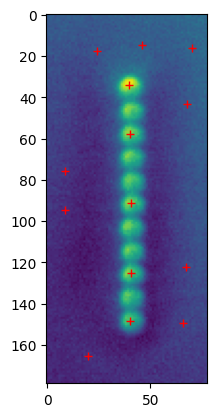

In [1]:
import trackpy as tp 
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

image = np.array(Image.open('./particledetection/beams/photos0000.tif'))
image = 255 - image # Invert image bright <-> dark
particles = tp.locate(image, 15)

fig, ax = plt.subplots()
plt.imshow(image)
plt.plot(particles['x'], particles['y'], 'r+')    # Hightlighting particle positions
plt.show()

Euh ... ? La détection de particules n'est pas vraiment terrible ... On a quatre particules correctement détectées, mais le reste est un joyeux bazar. Pourquoi donc ? À cela, deux raisons : 
* Des minima locaux d'intensité faible sont inclus alors qu'on souhaiterait les supprimer (_faux positifs_).
* Des endroits correspondant à des particules sont ignorés (_faux négatifs_), car ces particules sont trop proches les unes des autres par rapport à ce que l'algorithme accepte.

Pour régler ce problème, on va utiliser les options à notre disposition dans `tp.locate()`: 
- `minmass` : supprime tous les maxima détectés si leur moment $m_0$ (cf ci-dessus) est trop petit.
- `separation` : définit la séparation minimale entre particules (par défaut, `diameter + 1` pixel)

Vérifions par exemple les moments de nos particules, puis utilisons le résultat pour supprimer les particules. 

In [ ]:
particles

On a un assez gros saut de masses: pas mal de particules sont en dessous de $200$, tandis que les autres dépassent $950$ : on va donc essayer de placer notre `minmass` entre ces deux valeurs :  

In [ ]:
particles = tp.locate(image, 15, minmass=400)

fig, ax = plt.subplots()
plt.imshow(image)
plt.plot(particles['x'], particles['y'], 'r+')    # Hightlighting particle positions
plt.show()

C'est mieux, on a bien éliminé tous les faux positifs. Il nous reste toutefois encore beaucoup de faux négatifs ! Retrouvons-les en forçant le paramètre `separation`, par exemple en la fixant à $9$ pixels : 

In [ ]:
particles = tp.locate(image, 15, minmass=400, separation=9)

fig, ax = plt.subplots()
plt.imshow(image)
plt.plot(particles['x'], particles['y'], 'r+')    # Hightlighting particle positions
plt.show()

Et voilà ! Les particules sont correctement détectées. Facile, non ? 

Il existe de _nombreuses autres options_ si vous voulez pré-traiter vos images avant d'effectuer la détection de particules. Vous pouvez les examiner sur la page du manuel de [`trackpy.locate()`](http://soft-matter.github.io/trackpy/dev/generated/trackpy.locate.html#trackpy.locate).



__Exercice__ : Retrouvez les particules du fichier `/particledetection/Gel/Gel_0.png` correspondant à un gel colloïdal de particules de rayon ~500 µm. Essayez de supprimer les faux positifs / négatifs en jouant sur les différents paramètres de la fonction `tp.locate()`: 

In [ ]:
import trackpy as tp
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

img = Image.open('./particledetection/Gel/gel_0.png')

#### Localiser des particules sur plusieurs images avec `trackpy.batch()`  

Imaginons que vous avez 10, 100 voire 1000 images. Ce n'est pas _vraiment_ concevable d'appliquer `tp.locate()` à chacune des images ... et il serait pratique de pouvoir traiter à la volée une série d'images, non ? Eh bien ... c'est exactement le principe de `tp.batch()`. Cette fonction prend en entrée les mêmes paramètres que `tp.locate()`, à ceci près qu'elle demande une _série_ d'images et non une image unique.

Se pose donc la question fatidique ... « Comment donner à manger une série d'images à `tp.locate()` ? ». Pour cela, on va s'aider d'un module annexe appelé `pims`, qui nous permet d'ouvrir de nombreux formats : 
- des vidéos au format `.mp4` ou `.avi`
- des séries d'images au format `.png`, `.tif`, `.jpeg`, ... Vous pouvez pour cela utiliser des expressions régulières comme celles que nous avons vues pour le module [`glob`](./Tutorial_5_Files.ipynb)
- des `bio-formats` de microscopie, comme par exemple les `.lsm`, ... (via _encore un autre paquet additionnel, `jpype`_)

La fonction `pims.open()` nous renvoie assez simplement une liste d'images que `tp.batch()` comprend parfaitement. C'est un peu normal vu que les deux modules sont développés par les mêmes personnes :-). Si vous voulez _convertir_ des images couleur en nuances de gris, vous pouvez utiliser la fonction `as_grey()`  (ou `as_gray()`). Si vous voulez inverser vos images une fois converties en nuances de gris, vous pouvez utiliser le bout de code suivant que je n'explique pas, désolé*.

Le DataFrame qui est renvoyé par `tp.batch()` possède une colonne supplémentaire que celui renvoyé par `tp.locate()` : c'est tout naturellement l'image (`frame`) dans laquelle la particule est détectée.

<small>*Si cela vous intrigue, allez voir ce que sont des [_décorateurs_](https://realpython.com/primer-on-python-decorators/) de fonctions !</small>

In [ ]:
import pims
import trackpy as tp
import numpy as np
import matplotlib.pyplot as plt

images = pims.open('./particledetection/Beams/photos*.tif')
images = pims.as_grey(images)

### The snippet of code allowing to invert all frames
### from a pims sequence 
@pims.pipeline
def invert(frame):
    return 255 - frame
inv_images = invert(images)
### End of the snippet

particles = tp.batch(inv_images, 15, minmass=300, separation=9)

# Figure with particle detection on first and last image
fig, ax = plt.subplots(ncols=2)
ax[0].imshow(images[0])
ax[1].imshow(images[8])
ax[0].plot(particles.loc[particles['frame'] == 0, 'x'], 
           particles.loc[particles['frame'] == 0, 'y'], 'r+')
ax[1].plot(particles.loc[particles['frame'] == 8, 'x'], 
           particles.loc[particles['frame'] == 8, 'y'], 'r+')
plt.show()

#### Definir des trajectoires avec `trackpy.link()`

La fonction [`tp.link()`](http://soft-matter.github.io/trackpy/v0.5.0/generated/trackpy.link.html#trackpy.link) est très simple d'accès. Pour identifier des particules sur plusieurs image, elle a besoin en entrée 
- le DataFrame issu de `tp.batch()` (ou _n'importe quel DataFrame contenant les colonnes `x`, `y` et `frame`)
- une distance maximale de déplacement (en pixels). Si celle-ci est trop grande, l'algorithme va planter.
 
... et rien d'autre ! 

L'algorithme en fait tenter de faire une correspondance entre les particules de l'image $n$ et celle de l'image $n+1$. Il va pour cela supposer, par exemple, que la particule $4$ de l'image $n$ correspond à la particule $11$ de l'image $n+1$. Un tel choix est effectué pour toutes les particules ${1, ..., P}$ de l'image $n$, qui seront alors chacune associées à une particule ${j_1, ..., j_P}$ sur l'image $n+1$. On peut alors calculer la distance totale dont les particules se sont déplacées entre les deux images : 

$$ D = \sum_{p = 1}^P (x_p - x_{j_p})^2 + (y_p - y_{j_p})^2 $$ 

La correspondance entre les ${1, ..., P}$ et les ${j_1, ..., j_P}$ qui minimise $D$ est alors choisie. Une fois que toutes les paires d'images $n,n+1$ ont été traitées, l'algorithme vous renvoie votre DataFrame avec cette fois-ci une colonne `particle` correspondant à chacune des particules qui ont été correctement détectées sur (presque) toutes les images.

Essayons de voir ce que cela donne avec notre poutre de particules : 

In [ ]:
import pims
import trackpy as tp
import numpy as np
import matplotlib.pyplot as plt

@pims.pipeline
def invert(frame):
    return 255 - frame

images = pims.open('./particledetection/Beams/photos*.tif')
images = invert(pims.as_grey(images))
particles = tp.batch(images, 15, minmass=300, separation=9)
particles = tp.link(particles, 5)
n_particles = np.max(particles['particle']) + 1

fig, ax = plt.subplots()
for p_no in range(n_particles):
    now_particle = particles[particles['particle'] == p_no] # Selecting subset of data corresponding to a particle
    ax.imshow(images[0], cmap='gray')
    ax.plot(now_particle['x'], now_particle['y'])
plt.show()


Et voilà, c'est gagné ! 

Bon, on a pris un cas _vraiment simple_ ici. Sachez que parfois, les particules peuvent disparaître de votre champ de vision, devenir trop sombres pendant un court instant, ou se déplacer trop loin pour être correctement détectées. C'est _bien souvent_ le cas pour des particules qui se déplacent _beaucoup_ et _en bloc_. Regardez par exemple : 

In [ ]:
import pims
import trackpy as tp
import numpy as np
import matplotlib.pyplot as plt

images = pims.open('./particledetection/Gel/gel*.png')
images = pims.as_grey(images)
particles = tp.batch(images, 7, separation=5)
particles = tp.link(particles, 6)
n_particles = np.max(particles['particle']) + 1

fig, ax = plt.subplots()
ax.imshow(images[0], cmap='gray')
ax.plot(particles.loc[particles['frame'] == 0, 'x'],
        particles.loc[particles['frame'] == 0, 'y'],
        'g+')

for p_no in range(n_particles):
    now_particle = particles.loc[particles['particle'] == p_no] # Selecting subset of data corresponding to a particle
    ax.imshow(images[0], cmap='gray')
    ax.plot(now_particle['x'], now_particle['y'], 'g')

plt.show()

Eh eh ! Ce n'est pas si facile. Bien que notre oeil soit expert à détecter le mouvement 'en bloc' des particules, Trackpy n'est pas capable de le faire. Est-on alors condamné à ne pas pouvoir suivre des trajectoires ? _C'est possible, mais plus difficile_, car il faut donner à Trackpy une idée du déplacement des particules pour que `tp.link()` aille les trouver au bon endroit. Pour cela, on peut s'appuyer sur la _PIV_ !

### OpenPIV : la PIV (presque) simple 

OpenPIV est quasiment le seul acteur de la PIV en Python. Contrairement à Trackpy, il est un peu ... rudimentaire, et certaines options de PIV des logiciels commerciaux ne sont pas disponibles. 

Comment fonctionne la PIV ? L'idée initiale consiste à prendre une paire d'images (nommées ici 1 et 2). On divise l'image 1 en boîtes de taille $N \times N$ pixels. Pour chaque boîte, on va ensuite tenter de retrouver l'endroit dans l'image 2 qui ressemble le plus au contenu de ma boîte de l'image 1. On effectue pour cela une corrélation croisée entre la boîte de l'image 1 et des parties de (ou toute) l'image 2. Si les objets de la boîte n'ont pas bougé, le maximum de corrélation sera trouvé pour un décalage $(\delta x, \delta y)$ nul, mais si les objets de la boîte ont bougé suffisamment "en bloc" dans une direction, alors on trouvera un maximum de corrélation ailleurs, pour $(\delta x, \delta y) \neq (0,0)$. Ce maximum représente le déplacement local entre deux images, que l'on convertit en vitesse ensuite en divisant par la durée écoulée entre les deux images. [Une illustration plus visuelle du principe est disponible sur le site de Lavision®](https://www.piv.de/piv/measurement_principle/page_1.php).

#### PIV Simple

Ici, nous allons simplement calculer le déplacement entre une paire d'images, celle correspondant à notre gel préféré. Pour utiliser `openpiv`, on va principalement importer son sous-module `pyprocess` et utiliser deux fonctions : 

1. `pyprocess.get_coordinates()` renvoie les coordonnées de la grille 2d de vitesses PIV. Pour utiliser cette fonction, on a simplement besoin de :
- la taille des images, au format tuple `(height, width)` 
- une _taille de fenêtre de PIV_ (appelée ici improprement `search_area_size`) en pixels
- un _recouvrement_ entre fenêtres (`overlap`) qui indique de combien de pixels les fenêtres vont se recouvrir.

Elle renvoie un tuple des coordonnées $(x,y)$ au format tableau $2d$.

2. `pyprocess.extended_search_area_piv()` effectue les corrélations et calcule les déplacements. Elle a donc besoin de:
- l'image initiale `frame_0` [au format `np.ndarray()`]
- l'image finale `frame_1` , pour `extended_search_area_piv()`] ou plus simplement de 
- une _taille de fenêtre de PIV_ (ici appelée proprement `window_size`)
- le recouvrement entre fenêtres, `overlap` 
- [optionnellement] une _taille de zone de recherche_ (`search_area_size`, cette fois-ci pour de vrai). Je la laisse généralement à la même valeur que `window_size` même si je n'ai pas très bien compris pourquoi cela n'implique pas que tous mes déplacements doivent être égaux à 0 ...


Certaines autres options sont documentées sur la page d'[openPIV](https://openpiv.readthedocs.io/en/latest/src/api_reference.html). La fonction `extended_search_area_piv()` renvoie $u$, $v$, mais également $\delta$, qui représente le rapport signal sur bruit du processus de corrélation. 

Examinons donc la syntaxe de tout ça sur un exemple. On va afficher les deux images côte à côte et mettre en surimpression le champ de vitesses grâce à la fonction [`quiver()`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.quiver.html) de Matplotlib.

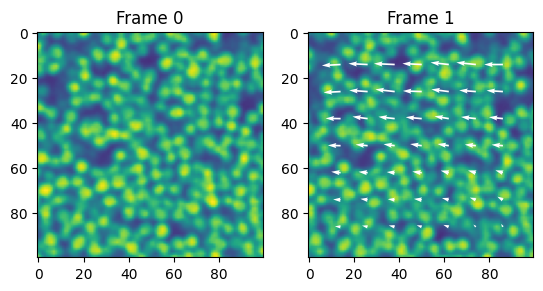

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pims
from openpiv import pyprocess

my_window_size = 24   # Initial image is 100 x 100 px, so we will have 4 x 4 windows
my_search_size = 48
my_overlap = 12

images = pims.open('./particledetection/Gel/gel*.png')
images = pims.as_gray(images)
frame_0, frame_1 = images[0], images[1]

x, y = pyprocess.get_coordinates(frame_0.shape, search_area_size=my_window_size, overlap=my_overlap)
u, v, deltas = pyprocess.extended_search_area_piv(frame_0, frame_1, window_size=my_window_size, overlap=my_overlap)

# Figure
fig, ax = plt.subplots(ncols=2)
ax[0].set_title(label='Frame 0')
ax[0].imshow(frame_0, vmin=0, vmax=255)
ax[1].imshow(frame_1, vmin=0, vmax=255)
ax[1].set_title(label='Frame 1')

ax[1].quiver(x,y,u,v, scale=100, color='w')
plt.show()

__Exercice__ : Déterminez le champ de vitesse associé au couple d'images du dossier `/particledetection/flow` . Jouez avec le facteur d'échelle `scale` de la fonction `quiver()` et avec la taille de fenêtres de corrélation `window_size` pour obtenir un résultat optimal. Vérifiez notamment si la qualité de la détection de déplacement (le `deltas`) augmente avec `window_size`.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pims
from openpiv import pyprocess

images = pims.open('./particledetection/Flow/flow*.jpg')
frame_0, frame_1 = pims.as_gray(images)


#### Pour aller plus loin ... 

Je ne connais pas _si bien_ le module `openpiv`, donc je vous laisse jeter un oeil à [la documentation](http://www.openpiv.net/openpiv-python/) d'openPIV sous Python. Sachez que : 

- il est possible de masquer des parties de l'image, mais celles-ci seront simplement _mises à zéro_ plutôt qu'ignorées, ce qui est loin d'être parfait ... 
- il n'est pas possible d'effectuer de la _piv adaptative_, c'est à dire d'effectuer plusieurs _passes_ avec des tailles de fenêtre décroissantes. 
- il a l'air possible d'effectuer de la PIV 3d, qui demande alors de corréler deux « tas » d'images (`stacks`) correspondant à des tableaux à 3 dimensions.

### Fu ..... sion ! Combiner PIV _et_ PTV



In [ ]:
import trackpy as tp
import numpy as np
from openpiv import pyprocess
import scipy.interpolate as spint
import scipy.spatial as spsp
import matplotlib.pyplot as plt
import pims
import time

import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact

@pims.pipeline
def invert(frame):
    return 255 - frame

images = pims.open('./particledetection/Gel/gel*.png')
images = pims.as_gray(images)
# images = invert(images)
x, y = pyprocess.get_coordinates(images[0].shape, overlap=10, search_area_size=24)
u, v, deltas = pyprocess.extended_search_area_piv(images[0], images[1], window_size=24, overlap=10)

# This guy has to "find back" what row in the dataframe
# corresponds to the current "point" before throwing
# the good predictor. 
# NOTE : point.uuid IS NOT THE DATAFRAME ROW !
@tp.predict.predictor
def predict(t1, point):
    x, y = point.pos[0], point.pos[1]
    index_in_df = particles.index[particles['x'] == x]
    u, v = float(particles.iloc[index_in_df]['u_piv']), float(particles.iloc[index_in_df]['v_piv'])
    return (x+u,y+v)

# Here, we do a nearest neighbor search to assign
# a velocity from PIV to each particle
particles = tp.batch(images, 7, separation=5)
xy_piv = np.array(list(zip(x.ravel(), y.ravel())))
uv_piv = np.array(list(zip(u.ravel(), v.ravel())))
xy_part = particles[['x', 'y']].to_numpy()
tree = spsp.KDTree(xy_piv, leafsize=20)
dists, neighb = tree.query(xy_part)

# Populating the tp.batch dataframe with extra PIV info
# Will be useful for the predictor
particles['u_piv'] = uv_piv[neighb,0]
particles['v_piv'] = uv_piv[neighb,1]
particles['u_ptv'] = 0
particles['v_ptv'] = 0

# Calling the linking routine with predictor
particle_l = tp.link(particles, 3, predictor=predict)
n_particles = np.max(particle_l['particle']) + 1

# Figure setup
fig, ax = plt.subplots()
img = ax.imshow(images[0], cmap='gray', origin='lower')
mkrs = ax.plot(particle_l.loc[particle_l['frame'] == 0, 'x'],
               particle_l.loc[particle_l['frame'] == 0, 'y'], 'r+')

for p_no in range(n_particles):
    now_part = particle_l.loc[particle_l['particle'] == p_no]
    xprt, yprt = now_part['x'].to_numpy(), now_part['y'].to_numpy()
    uplt, vplt = now_part['u_piv'].to_numpy(), now_part['v_piv'].to_numpy()
     
    if len(now_part) == 2:
        uptv, vptv = float(np.diff(now_part['x'])), float(np.diff(now_part['y']))
        particle_l.loc[particle_l['particle'] == p_no, 'u_ptv'] = uptv
        particle_l.loc[particle_l['particle'] == p_no, 'v_ptv'] = vptv
    else:
        uptv, vptv = 0, 0

    # ax.plot([xprt[0],xprt[0]+uplt[0]],[yprt[0],yprt[0]+vplt[0]], 'r')
    ax.plot([xprt[0],xprt[0]+uptv],   [yprt[0],yprt[0]+vptv]   , 'g')
        
# Update figure routine
def update_figure(n=0):
    img.set_data(images[n])
    mkrs[0].set_xdata(particles.loc[particles['frame'] == n, 'x'])
    mkrs[0].set_ydata(particles.loc[particles['frame'] == n, 'y'])

anim = interact(update_figure, n=(0,1))
plt.show()